In [1]:
from __future__ import print_function, division

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import copy
import torchsummary
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
from barbar import Bar
import pandas as pd
cudnn.benchmark = True
plt.ion()   # interactive mode

selected_gpu = 1 # here you select the GPU used (0, 1 or 2)
device = torch.device("cuda:" + str(selected_gpu) if
torch.cuda.is_available() else "cpu")
print(f'the device is {device}')


the device is cpu


In [2]:
#if running locally
notebook_path = Path().cwd()
#if running in colab
# from google.colab import drive
# drive._mount('/content/drive')
#notebook_path = Path('/content/drive/MyDrive/MAIA/3rd_semester/CAD/Projecte/Deep_Learning/notebooks')

project_path = notebook_path.parent
repo_path = project_path.parent
os.chdir(notebook_path)
print(f'The current directory is {Path().cwd()}')

The current directory is /home/ricardino/Documents/MAIA/tercer_semestre/CAD/Projecte/Deep_Learning/notebooks


# MAIN

## Accuracy and loss

Text(0.5, 1.0, 'Googlenet accuracy')

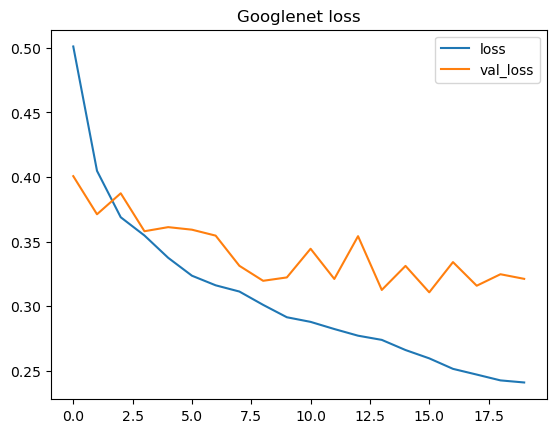

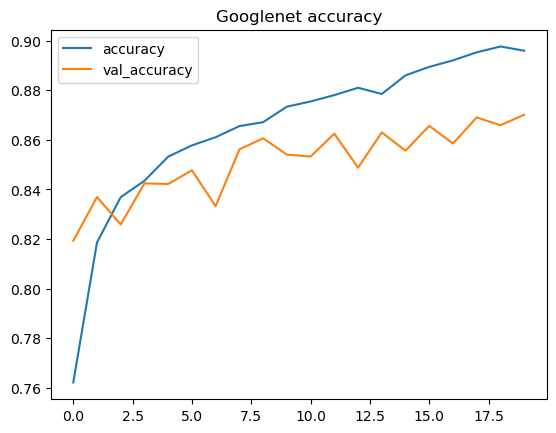

In [14]:
# Let's check the loss and accuracy of the model
model_name = 'googlenet'
#statistics path
statistics_pah = project_path / 'data'/'results' / f'{model_name}_stats.csv'
#read csv file
df = pd.read_csv(statistics_pah)
#plot loss and validation loss
df[['loss', 'val_loss']].plot()
plt.title(f'{model_name.capitalize()} loss')
#plot accuracy and validation accuracy
df[['accuracy', 'val_accuracy']].plot()
plt.title(f'{model_name.capitalize()} accuracy')

## Confusion matrix